# Chapter 8 - Tree-based Methods

- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [4]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


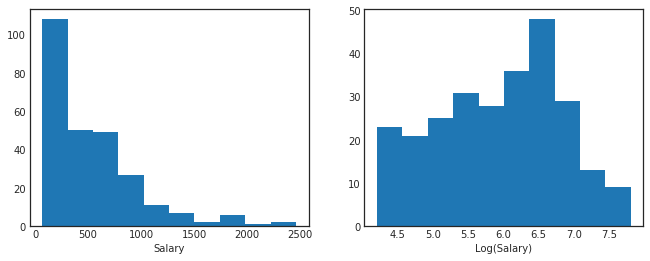

In [5]:
X = df[['Years', 'Hits']].as_matrix()
y = np.log(df.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [6]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Figure 8.1

In [7]:
# graph, = print_tree(regr, features=['Years', 'Hits'])
# Image(graph.create_png())

###  Figure 8.2

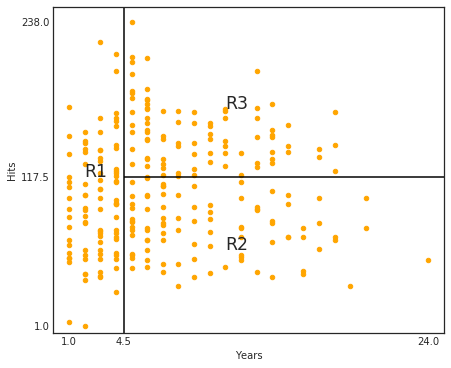

In [8]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

### 8.1.2 Classification Trees

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [9]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null object
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null object
AHD          297 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [31]:
df2.apply(lambda x:print(len(x)),axis=0)

297
297
297
297
297
297
297
297
297
297
297
297
297
297


Age          None
Sex          None
ChestPain    None
RestBP       None
Chol         None
Fbs          None
RestECG      None
MaxHR        None
ExAng        None
Oldpeak      None
Slope        None
Ca           None
Thal         None
AHD          None
dtype: object

In [10]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [11]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [12]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [13]:
clf.score(X2,y2)

0.7575757575757576

In [14]:
graph2, = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

NameError: name 'pydot' is not defined

## Lab

### 8.3.1 Fitting Classification Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [15]:
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [16]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int64
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int64
US             400 non-null int64
High           400 non-null int64
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [17]:
df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [18]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [19]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
print(classification_report(y, clf.predict(X)))

             precision    recall  f1-score   support

          0       0.89      0.99      0.93       236
          1       0.98      0.82      0.89       164

avg / total       0.92      0.92      0.92       400



In [ ]:
# graph3, = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
# Image(graph3.create_png())

In [21]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [22]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,100,31
Yes,18,51


In [23]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.76      0.85      0.80       118
          1       0.74      0.62      0.68        82

avg / total       0.75      0.76      0.75       200



Pruning not implemented in scikit-learn.

### 8.3.2 Fitting Regression Trees

In R, I exported the dataset from package 'MASS' to a csv file.

In [24]:
boston_df = pd.read_csv('Data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


In [25]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [26]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

In [27]:
graph, = print_tree(regr2, features=X.columns)
Image(graph.create_png())

NameError: name 'pydot' is not defined

In [ ]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
mean_squared_error(y_test, pred)

### 8.3.3 Bagging and Random Forests

In [ ]:
# There are 13 features in the dataset
X.shape

In [ ]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=13, random_state=1)
regr1.fit(X_train, y_train)

In [ ]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=1)
regr2.fit(X_train, y_train)

In [ ]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

In [ ]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### 8.3.4 Boosting

In [32]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

zn          0.170382
rad         1.593909
chas        1.844703
indus       3.045285
nox         3.284683
tax         5.007437
black       5.082208
age         5.587239
crim        6.750284
ptratio     8.226473
dis        10.248698
rm         22.134290
lstat      27.024410
dtype: float64


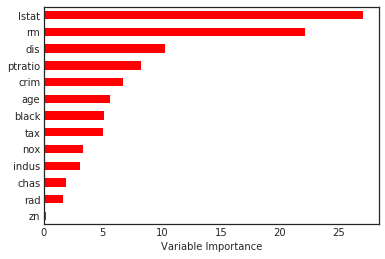

In [33]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [34]:
mean_squared_error(y_test, regr.predict(X_test))

15.529710264059759